## **Lab 2**

### **Part 3. Poetry generation**

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

заимпортим необходимые модули

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### **Data loading: Shakespeare**

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [4]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [5]:
# Join all the strings into one and lowercase it
# Put result into variable text.
text = ''.join([x.lower() for x in text]).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### **Data loading: "Евгений Онегин"**


In [6]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text_onegin = iofile.readlines()
    
text_onegin = [x.replace('\t\t', '') for x in text_onegin]

--2021-12-17 19:56:17--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.4’

onegin.txt.4        100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2021-12-17 19:56:17 (8.24 MB/s) - ‘onegin.txt.4’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [7]:
# Join all the strings into one and lowercase it
# Put result into variable text.
text_onegin = "".join([x.lower() for x in text_onegin])

Put all the characters, that you've seen in the text, into variable `tokens`, заодно и выясним длину множества

In [8]:
tokens = sorted(set(text))
len(tokens)

38

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [9]:
# dict <index>:<char>
idx_to_token = {i: token for i, token in enumerate(tokens)}

# dict <char>:<index>
token_to_idx = {token: i for i, token in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [10]:
sentences = [] 
next_tokens = []
for i in range(0, len(text) - 64, 1):
    sentences.append(text[i : i + 64])
    next_tokens.append(text[i + 64])

x = np.zeros((len(sentences), 64, len(tokens)))
y = np.zeros((len(sentences), len(tokens)))

for i, sentence in enumerate(sentences):
    for t, token in enumerate(sentence):
        x[i, t, token_to_idx[token]] = 1
    y[i, token_to_idx[next_tokens[i]]] = 1  


In [11]:
print(x.shape)

(100161, 64, 38)


### **Building the model**

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [12]:
# Your code here
class RNN(nn.Module):
    def __init__(self, n_tokens = len(tokens), hidden_dim = 128, emb_dim = 128, n_layers = 1):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        self.n_tokens = n_tokens
        
        self.embed = nn.Embedding(n_tokens, self.emb_dim)
        self.rnn = nn.RNN(self.emb_dim, self.hidden_dim, batch_first =  True)
        self.dropout  = nn.Dropout(.35)
        self.hid_to_logits = nn.Linear(self.hidden_dim, n_tokens)
    
    def forward(self, x, h_prev):
        h_seq, h = self.rnn(self.embed(x), h_prev)
        h_seq = self.dropout(h_seq)
        next_logits = self.hid_to_logits(h_seq)
        return next_logits, h
    
    def initial_state(self, batch_size):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)

In [13]:
def get_batches(x, y, device, batch_size, batch_ind):
    x_batch = torch.argmax(torch.Tensor(x[batch_ind - batch_size : batch_ind]), dim = -1).to(device)
    y_batch = torch.argmax(torch.Tensor(y[batch_ind - batch_size : batch_ind]), dim = -1).to(device)

    return x_batch, y_batch

In [14]:
def train_model(model, epochs=800):
    torch.manual_seed(7)
    batch_size = 512
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    loss_history = []

    model.train()

    for epoch in range(1, epochs+1):
        curr_loss = []
        hidden_state = model.initial_state(batch_size)

        for batch_ind in range(batch_size, x.shape[0], batch_size):         
            optimizer.zero_grad()
            x_batch, y_batch = get_batches(x, y, device, batch_size, batch_ind)

            optimizer.zero_grad()
            seq, hidden_state = model(x_batch, hidden_state)
            loss = criterion(seq[:, -1].contiguous(), y_batch.contiguous())  
            loss.backward()
            optimizer.step()  
            curr_loss.append(loss.item())
            hidden_state = hidden_state.detach()

        loss_history.append(np.mean(curr_loss))
        if epoch % 5 == 0:
            print(f'epoch {epoch}')
            print(f'loss {loss_history[-1]}')
            
    #visualize
    plt.figure(figsize=(18,7))
    plt.plot(loss_history, label = 'loss')
    plt.xlabel("epochs")
    plt.legend()
    plt.show()

Plot the loss function (axis X: number of epochs, axis Y: loss function).

epoch 5
current loss 1.8743894540346586
epoch 10
current loss 1.7874047554456272
epoch 15
current loss 1.7406635431142954
epoch 20
current loss 1.7136856317520142
epoch 25
current loss 1.6925207180854602
epoch 30
current loss 1.6745837015983387
epoch 35
current loss 1.662872716708061
epoch 40
current loss 1.6525868819310114
epoch 45
current loss 1.6398234459070058
epoch 50
current loss 1.6379779797333938
epoch 55
current loss 1.6258083942608956
epoch 60
current loss 1.620752812654544
epoch 65
current loss 1.6169992489692493
epoch 70
current loss 1.6141981314390133
epoch 75
current loss 1.6090634077023238


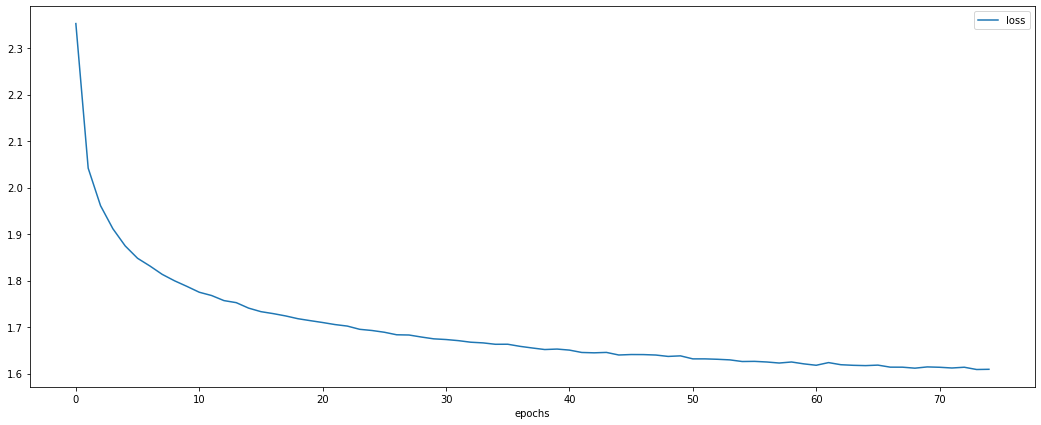

In [15]:
model_rnn = RNN()
model_rnn.to(device)

epochs = 75

train_model(model_rnn, epochs)

In [16]:
def generate_text(char_rnn, tokens = tokens, seed_phrase = 'darling, ', max_length = 100, temperature = 1., flag = False): 
    x_sequence = torch.Tensor([np.array([token_to_idx[token] for token in seed_phrase.lower()])]).to(device)
    hid_state = char_rnn.initial_state(batch_size = 1)

    if flag: hid_state = tuple([each.data for each in hid_state])
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(torch.stack([x_sequence[:, -1].long()]), hid_state)
        preds =  F.softmax(out / temperature, dim = -1).cpu().data.numpy().squeeze()
        next_ix_ = np.random.choice(len(tokens), p = preds)
        next_ix = torch.LongTensor([[next_ix_]])

        x_sequence = torch.cat([x_sequence, next_ix.to(device)], dim = 1)

    return ''.join([tokens[int(ix)] for ix in x_sequence.cpu().data.numpy()[0]])

In [17]:
model_rnn.eval()
print(generate_text(char_rnn = model_rnn,  max_length = 500, temperature = 1.))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


darling, thisu arast say whingo the proud with tse cweal'd,
  i hos ating this me faar their, ane gonings,
  when his may, thou forselfo good, tofnen is my lades i lare, th me thet be thrance.
  is woor my undired noth.

  cxxxvi

  th it men to mine frinese.
  you.

  cxxxiv

  thy shalt my love,s nath,
  whics her in ost,
  out to laid me,
  unkindd
  and tumingss one,
  y of iover hane, what tho, not and days me is way stumber deast,
  and still,
    fall
  my lever on a false, it,
  which an


### **More poetic model**

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [25]:
class LSTM (nn.Module):
    def __init__(self, n_tokens = len(tokens), hidden_dim = 256, emb_dim = 128, n_layers = 1):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        self.n_tokens = emb_dim
        self.embed = nn.Embedding(n_tokens, self.emb_dim)
        self.lstm = nn.LSTM(self.emb_dim, self.hidden_dim, batch_first =  True)
        self.hid_to_logits = nn.Linear(self.hidden_dim, n_tokens)
    
    def forward(self, x, hidden_state):
        out, hidden_state = self.lstm(self.embed(x), hidden_state)
        out = self.hid_to_logits(out)
        return out, hidden_state
    
    def initial_state(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
        weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [26]:
def train_model_lstm(model, epochs=800):
    torch.manual_seed(7)
    batch_size = 512
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    loss_history = []

    model.train()

    for epoch in range(1, epochs+1):
        curr_loss = []
        hidden_state = model.initial_state(batch_size)

        for batch_ind in range(batch_size, x.shape[0], batch_size):
            x_batch, y_batch = get_batches(x, y, device, batch_size, batch_ind)
            hidden_state = tuple([each.data for each in hidden_state])

            optimizer.zero_grad()
            seq, hidden_state = model_lstm(x_batch, hidden_state)
            loss = criterion(seq[:, -1].contiguous(), y_batch.contiguous())  
            loss.backward()
            optimizer.step()
            curr_loss.append(loss.item())  

        loss_history.append(np.mean(curr_loss))
        if epoch % 5 == 0:
            print(f'epoch {epoch}')
            print(f'loss {loss_history[-1]}')
            
    #visualize
    plt.figure(figsize=(18,7))
    plt.plot(loss_history, label = 'loss')
    plt.xlabel("epochs")
    plt.legend()
    plt.show()

epoch 5
loss 1.5147328450129582
epoch 10
loss 1.3301257591981155
epoch 15
loss 1.2047754678970728
epoch 20
loss 1.0852965275446573
epoch 25
loss 0.9641323578663361
epoch 30
loss 0.8831740856170655
epoch 35
loss 0.8086255321135888
epoch 40
loss 0.7325671507762028
epoch 45
loss 0.6782505527520791
epoch 50
loss 0.6045076730923775
epoch 55
loss 0.5684018668455956
epoch 60
loss 0.5209186046551435
epoch 65
loss 0.47755273641684115
epoch 70
loss 0.4422441487128918
epoch 75
loss 0.4198530152822152


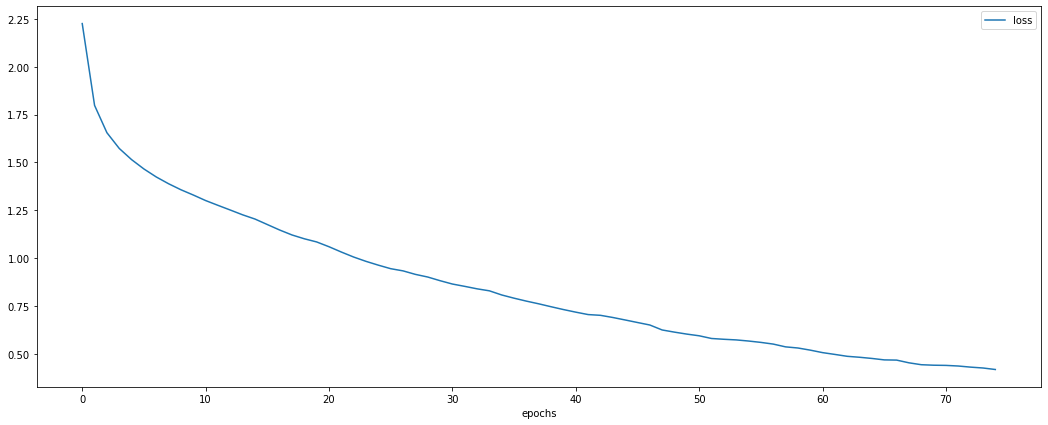

In [27]:
model_lstm = LSTM()
model_lstm.to(device)

epochs = 75

train_model_lstm(model_lstm, epochs)

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [28]:
# Text generation with different temperature values here
model_lstm.eval()

for temperature in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print("TEMPERATURE = ", temperature)
    poetry = generate_text(char_rnn = model_lstm, temperature = temperature, max_length = 400, seed_phrase = "Darling, ")

    print('\t', poetry, '\n')

TEMPERATURE =  0.1
	 darling, true sight
  as thou being mine is thy song, self so strange?
  why dost thou pleasure of death doth dwell
  that love is my heart think that lovely knife,
  and all my absence save whereon belied?
    because her bad and in my mistress reeds.

  xci

  how like a sweetly hand the willing look,
  pointing to heart to suffering to belov'd,
    then better'd love to hear we proud fold,
  th 

TEMPERATURE =  0.2
	 darling, true sight
  as thou being mine is thy song, self so strange?
  why dost thou pleasure of decay'd with thee,
  who leaves so long as you desire,
  that heavy sake love, sick of the tender much trage
  as he that cannot contented founds hate,
  stain the rest, follow i am forsworn,
  and see the tillers what we see doth lie:
  the wastes of thy sweet self to die.

  cxliv

  when thou shal 

TEMPERATURE =  0.5
	 darling, true short.
  weeds not silent thou lov'st me blest,
  making no lame with this poor state out on thee,
  who wills not wh

При teperature = 0.2 - 0.5 тексты получились достаточно красивые и похожи на реальные

При teperature > 0.5 увеличивается процент ошибок в орфографии

### **Saving and loading models**

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [29]:
# Saving and loading code here
def save_net(net, name: str, opt):
    checkpoint = {'state_dict': net.state_dict(),
                  'opt_state_dict': opt.state_dict()}

    with open(name, 'wb') as f:
        torch.save(checkpoint, f)

In [30]:
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
save_net(model_lstm, "LSTM.net", optimizer)

checkpoint = torch.load("LSTM.net")
model_lstm.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['opt_state_dict'])
model_lstm.eval()

LSTM(
  (embed): Embedding(38, 128)
  (lstm): LSTM(128, 256, batch_first=True)
  (hid_to_logits): Linear(in_features=256, out_features=38, bias=True)
)

In [31]:
print(generate_text(char_rnn = model_lstm, temperature = 1., max_length = 450, seed_phrase = "Darling! "))

darling! alone,
    when i but in happy to make the rest face,
  wear it that my spirit pen call;
  when others were blank render,
  they all cheeks hath not sick and more ragh'd,
  sick of receive that say they drivide;
  look piect of wrom care, and i assay's eless wink,
  when others wear the true comes rengars.

  cxxxxii

  thou mayst in thee and more will of tenceit,
  and in that so errors normers hate,
  all my name rehembers with his poe


### **References**
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)